# Install & import modules

In [20]:
# !python.exe -m pip install --upgrade pip
# !pip install tensorflow
# !pip install --upgrade imbalanced-learn
# !pip install xgboost
# !pip install keras-tuner
# !pip install tensorflow-gpu
# !pip install tensorflow-addons

In [21]:
import tensorflow as tf

print("Wersja TensorFlow:", tf.__version__)
print("Dostępne urządzenia GPU:")
print(tf.config.list_physical_devices('GPU'))

Wersja TensorFlow: 2.18.0
Dostępne urządzenia GPU:
[]


In [22]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import (
    make_scorer,
    precision_score,
    roc_auc_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    balanced_accuracy_score, 
    log_loss, 
    matthews_corrcoef, 
    precision_recall_curve, 
    auc, 
    cohen_kappa_score,
    f1_score, precision_score, recall_score, roc_auc_score,
    average_precision_score, matthews_corrcoef, balanced_accuracy_score
)
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.utils import class_weight

from imblearn.over_sampling import ADASYN, BorderlineSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import EditedNearestNeighbours, ClusterCentroids

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
from tensorflow.keras.metrics import Precision, AUC, F1Score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner.tuners import BayesianOptimization, Hyperband

import xgboost as xgb

from pymoo.core.problem import ElementwiseProblem
from pymoo.core.variable import Real, Integer, Choice, Binary
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.core.mixed import (
    MixedVariableMating,
    MixedVariableSampling,
    MixedVariableDuplicateElimination,
)
from pymoo.core.problem import StarmapParallelization
from pymoo.optimize import minimize

# Settings/Constant variables

In [23]:
# Constant Variables
RND_STATE = 37
NN_METRIC = f1_score
TUNING_SCORER = f1_score
TUNING_NGEN = 50
TUNING_POPSIZE = 32
# For min-max scaled data use: minmax_modeling.csv
DATASET_FILENAME = "std_modeling.csv"
# BALANCE_METHOD = ''

# Custom functions

In [24]:
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def balanced_accuracy(y_true, y_pred):
    # Convert predictions to binary values
    y_pred_classes = K.cast(K.greater(y_pred, 0.5), K.floatx())

    # True positives, true negatives, false positives, false negatives
    true_positives = K.sum(y_true * y_pred_classes)
    true_negatives = K.sum((1 - y_true) * (1 - y_pred_classes))
    false_positives = K.sum((1 - y_true) * y_pred_classes)
    false_negatives = K.sum(y_true * (1 - y_pred_classes))

    # Sensitivity and Specificity
    sensitivity = true_positives / (true_positives + false_negatives + K.epsilon())
    specificity = true_negatives / (true_negatives + false_positives + K.epsilon())

    # Balanced Accuracy
    balanced_acc = (sensitivity + specificity) / 2
    return balanced_acc

# def f1_score(y_true, y_pred):
#     y_pred = tf.round(y_pred)

#     tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
#     fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
#     fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)

#     precision = tp / (tp + fp + K.epsilon())
#     recall = tp / (tp + fn + K.epsilon())

#     f1 = 2 * precision * recall / (precision + recall + K.epsilon())
#     return K.mean(f1)

# Read data

Observations with worthy class: 942 (0.92%)


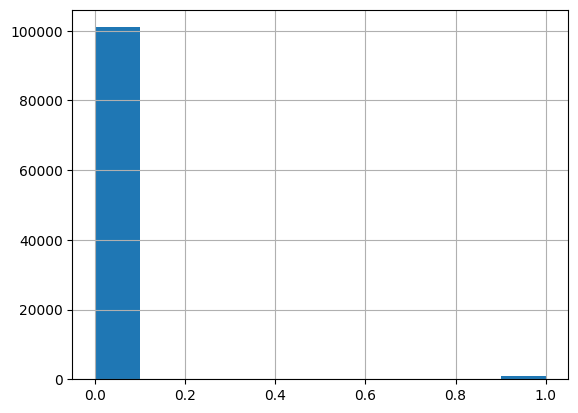

In [25]:
# Load dataset
modeling = pd.read_csv(f"data/{DATASET_FILENAME}")

worth = modeling[modeling["worthy"] == 1]
not_worth = modeling[modeling["worthy"] == 0]

modeling["worthy"].hist()
print(
    f"Observations with worthy class: {len(worth)} ({len(worth)/modeling.shape[0]*100:.2f}%)"
)

In [26]:
X = modeling.drop(columns=["worthy"])
y = modeling["worthy"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RND_STATE
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((81552, 140), (20388, 140), (81552,), (20388,))

In [27]:
X_test.describe()

,priceNative,priceUsd,txns_m5_buys,txns_m5_sells,txns_h1_buys,txns_h1_sells,txns_h6_buys,txns_h6_sells,txns_h24_buy,txns_h24_sells,...,symbolVectorDim5,symbolVectorDim6,symbolVectorDim7,symbolVectorDim8,symbolVectorDim9,symbolVectorDim10,symbolVectorDim11,symbolVectorDim12,symbolVectorDim13,symbolVectorDim14
count,20388.000000,20388.000000,20388.000000,20388.000000,20388.000000,20388.000000,20388.000000,20388.000000,20388.000000,20388.000000,...,20388.000000,20388.000000,20388.000000,20388.000000,20388.000000,20388.000000,20388.000000,20388.000000,20388.000000,20388.000000
mean,0.000269,-0.000624,0.002254,0.001772,0.001762,0.001019,0.001762,0.001019,0.001762,0.001019,...,0.001796,-0.013774,0.009737,0.008746,0.009582,-0.010415,0.010154,0.009461,0.013428,-0.008425
std,0.584665,0.367009,0.974745,0.996011,0.978960,0.996667,0.978960,0.996667,0.978960,0.996667,...,0.997976,0.995424,0.994053,0.993051,0.993552,0.994173,0.993441,0.993851,0.996378,0.994309
min,-0.004804,-0.004086,-0.580210,-0.467677,-0.573400,-0.461369,-0.573400,-0.461369,-0.573400,-0.461369,...,-4.847403,-2.338401,-4.007145,-3.890414,-3.873860,-1.037794,-3.988849,-3.937152,-4.667110,-1.384749
25%,-0.004804,-0.004086,-0.524078,-0.467677,-0.518793,-0.461369,-0.518793,-0.461369,-0.518793,-0.461369,...,-0.618837,-0.658055,-0.145479,-0.156082,-0.127360,-0.604605,-0.136258,-0.129904,-0.259725,-0.614571
50%,-0.004804,-0.004086,-0.313582,-0.406082,-0.307190,-0.401406,-0.307190,-0.401406,-0.307190,-0.401406,...,0.067995,-0.355611,0.506397,0.500747,0.530133,-0.513816,0.522656,0.523527,0.388589,-0.490325
75%,-0.004804,-0.004086,0.177577,0.055878,0.163798,0.048314,0.163798,0.048314,0.163798,0.048314,...,0.677858,0.283411,0.606439,0.607393,0.594895,0.132198,0.593886,0.593294,0.665024,0.153123
max,80.521139,47.040394,20.967621,17.979942,20.388951,20.525562,20.388951,20.525562,20.388951,20.525562,...,3.968924,4.546176,1.158740,1.141238,0.979010,4.207098,0.975888,0.951877,2.083998,3.709060


## Under/Over sampling

In [28]:
# if BALANCE_METHOD == 'smote':
#     smote = SMOTE(random_state=RND_STATE)
#     X_train, y_train = smote.fit_resample(X_train, y_train)
# elif BALANCE_METHOD == 'adasyn':
#     adasyn = ADASYN(random_state=RND_STATE)
#     X_train, y_train = adasyn.fit_resample(X_train, y_train)
# elif BALANCE_METHOD == 'smote_borderline':
#     borderline_smote = BorderlineSMOTE(random_state=RND_STATE)
#     X_train, y_train = borderline_smote.fit_resample(X_train, y_train)
# elif BALANCE_METHOD == 'smote_enn':
#     smote_enn = SMOTEENN(random_state=RND_STATE)
#     X_train, y_train = smote_enn.fit_resample(X_train, y_train)
# elif BALANCE_METHOD == 'smote_tomek':
#     smote_tomek = SMOTETomek(random_state=RND_STATE)
#     X_train, y_train = smote_tomek.fit_resample(X_train, y_train)
# elif BALANCE_METHOD == 'enn':
#     enn = EditedNearestNeighbours()
#     X_train, y_train = enn.fit_resample(X_train, y_train)
# elif BALANCE_METHOD == 'cc':
#     cc = ClusterCentroids(random_state=RND_STATE)
#     X_train, y_train = cc.fit_resample(X_train, y_train)
# elif BALANCE_METHOD == 'all':
#     smote = SMOTE(random_state=RND_STATE)
#     adasyn = ADASYN(random_state=RND_STATE)
#     borderline_smote = BorderlineSMOTE(random_state=RND_STATE)
#     smote_enn = SMOTEENN(random_state=RND_STATE)
#     smote_tomek = SMOTETomek(random_state=RND_STATE)
#     enn = EditedNearestNeighbours()
#     cc = ClusterCentroids(random_state=RND_STATE)

#     X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
#     X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)
#     X_train_borderline, y_train_borderline = borderline_smote.fit_resample(X_train, y_train)
#     X_train_smote_enn, y_train_smote_enn = smote_enn.fit_resample(X_train, y_train)
#     X_train_tomek, y_train_tomek = smote_tomek.fit_resample(X_train, y_train)
#     X_train_enn, y_train_enn = enn.fit_resample(X_train, y_train)
#     X_train_cc, y_train_cc = cc.fit_resample(X_train, y_train)
# else:
#     pass

In [29]:
class default:
    def fit_resample(self, X, y):
        return X, y

balance_methods = {
    'smote': SMOTE(random_state=RND_STATE),
    'adasyn': ADASYN(random_state=RND_STATE),
    'smote_borderline': BorderlineSMOTE(random_state=RND_STATE),
    'smote_enn': SMOTEENN(random_state=RND_STATE),
    'smote_tomek': SMOTETomek(random_state=RND_STATE),
    'enn': EditedNearestNeighbours(),
    'cc': ClusterCentroids(random_state=RND_STATE),
    'default': default()
}

# Default models

## Random Forest

In [30]:
# OLD
# rf_model = RandomForestClassifier(
#         class_weight="balanced",
#         n_jobs=-1,
#         random_state=RND_STATE,
#     )
# brf_model = BalancedRandomForestClassifier(
#         replacement=True,
#         bootstrap=False,
#         class_weight="balanced",
#         sampling_strategy="auto",
#         n_jobs=-1,
#         random_state=RND_STATE)
# # Trenowanie modelu na danych treningowych
# rf_model.fit(X_train, y_train)
# joblib.dump(rf_model, "models/default_rf_model.joblib")
# # Przewidywanie na zbiorze testowym
# y_pred = rf_model.predict(X_test)
# y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

best_mcc = -1
best_method = None
best_model = None
best_model_type = None  # 'RandomForest' lub 'BalancedRandomForest'

# Lista do przechowywania wszystkich wyników
results_all = []

for method_name, sampler in balance_methods.items():
    # Balansowanie danych
    X_res, y_res = sampler.fit_resample(X_train, y_train)
    
    # Definicja modeli do trenowania
    models = {
        'RandomForest': RandomForestClassifier(
            class_weight="balanced",
            n_jobs=-1,
            random_state=RND_STATE
        ),
        'BalancedRandomForest': BalancedRandomForestClassifier(
            replacement=True,
            bootstrap=False,
            class_weight="balanced",
            sampling_strategy="auto",
            n_jobs=-1,
            random_state=RND_STATE
        )
    }
    
    for model_type, model in models.items():
        # Trenowanie modelu
        model.fit(X_res, y_res)
        
        # Predykcje
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Obliczanie metryk
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        pr_auc = average_precision_score(y_test, y_pred_proba)
        mcc = matthews_corrcoef(y_test, y_pred)
        balanced_acc = balanced_accuracy_score(y_test, y_pred)
        
        # Zapisywanie wyników
        results_all.append({
            'Method': method_name,
            'Model': model_type,
            'F1 Score': f1,
            'Precision': precision,
            'Recall': recall,
            'AUC': auc_score,
            'PR AUC': pr_auc,
            'MCC': mcc,
            'Balanced Accuracy': balanced_acc
        })
        
        # Wyświetlanie metryk
        print(f"{model_type} - Metoda: {method_name}")
        print(f"SCORES: f1: {f1:.4f}, prec: {precision:.4f}, recall: {recall:.4f}, "
              f"auc: {auc_score:.4f}, pr_auc: {pr_auc:.4f}, mcc: {mcc:.4f}, "
              f"balanced_acc: {balanced_acc:.4f}\n")
        
        # Aktualizacja najlepszego modelu na podstawie F1 Score
        if mcc > best_mcc:
            best_mcc = mcc
            best_method = method_name
            best_model = model
            best_model_type = model_type

# Zapis najlepszego modelu jako default_rf_model.joblib
if best_model:
    best_model_filename = "models/default_rf_model.joblib"
    joblib.dump(best_model, best_model_filename)
    print(f"Najlepszy model: {best_model_type} - Metoda: {best_method} z MCC Score = {best_mcc:.4f}")
    print(f"Najlepszy model zapisany jako: {best_model_filename}")

# Tworzenie DataFrame z wynikami
results_df = pd.DataFrame(results_all)
print("\nPodsumowanie wszystkich wyników:")
print(results_df)

RandomForest - Metoda: smote
SCORES: f1: 0.0078, prec: 0.0149, recall: 0.0053, auc: 0.7651, pr_auc: 0.0240, mcc: 0.0034, balanced_acc: 0.5010

BalancedRandomForest - Metoda: smote
SCORES: f1: 0.0090, prec: 0.0294, recall: 0.0053, auc: 0.7648, pr_auc: 0.0238, mcc: 0.0086, balanced_acc: 0.5018

RandomForest - Metoda: adasyn
SCORES: f1: 0.0080, prec: 0.0161, recall: 0.0053, auc: 0.7747, pr_auc: 0.0255, mcc: 0.0040, balanced_acc: 0.5011

BalancedRandomForest - Metoda: adasyn
SCORES: f1: 0.0000, prec: 0.0000, recall: 0.0000, auc: 0.7717, pr_auc: 0.0242, mcc: -0.0033, balanced_acc: 0.4994

RandomForest - Metoda: smote_borderline
SCORES: f1: 0.0000, prec: 0.0000, recall: 0.0000, auc: 0.7139, pr_auc: 0.0204, mcc: -0.0028, balanced_acc: 0.4996

BalancedRandomForest - Metoda: smote_borderline
SCORES: f1: 0.0000, prec: 0.0000, recall: 0.0000, auc: 0.6737, pr_auc: 0.0184, mcc: -0.0021, balanced_acc: 0.4998

RandomForest - Metoda: smote_enn
SCORES: f1: 0.0063, prec: 0.0079, recall: 0.0053, auc: 0.7

SCORES: f1: 0.0398, prec: 0.0206, auc: 0.7164

              precision    recall  f1-score   support

         0.0       1.00      0.73      0.84     20200
         1.0       0.02      0.62      0.04       188

    accuracy                           0.73     20388
   macro avg       0.51      0.67      0.44     20388
weighted avg       0.99      0.73      0.83     20388



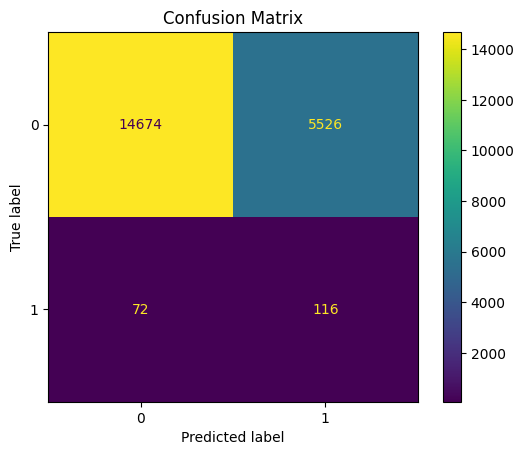

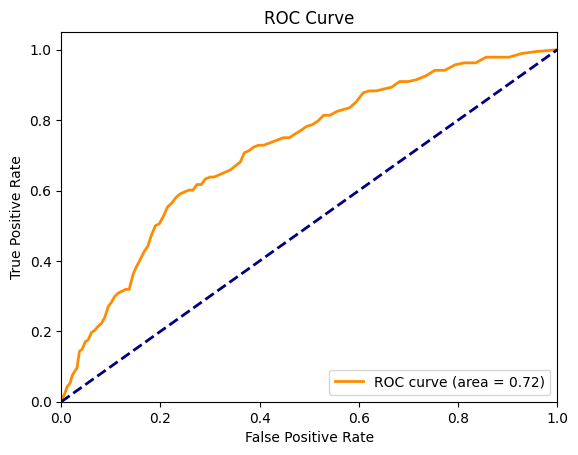

In [31]:
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Ocena modelu
_f1_score = f1_score(y_test, y_pred)
_precision = precision_score(y_test, y_pred)
_auc = roc_auc_score(y_test, y_pred_proba)
print(
    f"SCORES: f1: {_f1_score:.4f}, prec: {_precision:.4f}, auc: {_auc:.4f}", end="\n\n"
)
# Dodatkowa ocena za pomocą classification report
report = classification_report(y_test, y_pred)
print(report)

# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Krzywa ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

C:\Users\philipz\AppData\Local\Temp\ipykernel_18000\1493832135.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


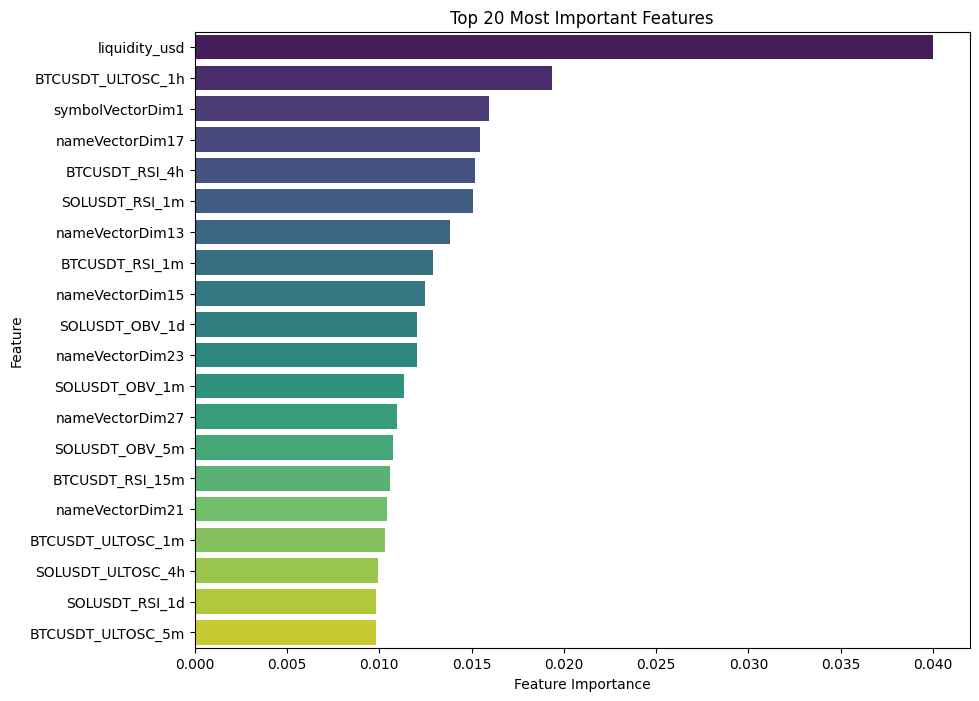

In [32]:
# Obliczanie średniej ważności cech
feature_importances = best_model.estimators_[0].feature_importances_
for estimator in best_model.estimators_[1:]:
    feature_importances += estimator.feature_importances_
feature_importances /= len(best_model.estimators_)

# Tworzenie DataFrame z ważnościami cech
feature_importance_df = pd.DataFrame(
    {"Feature": X.columns, "Importance": feature_importances}
)

# Sortowanie cech według ważności
feature_importance_df = feature_importance_df.sort_values(
    by="Importance", ascending=False
)

# Rysowanie wykresu ważności cech
plt.figure(figsize=(10, 8))
sns.barplot(
    data=feature_importance_df.head(20), x="Importance", y="Feature", palette="viridis"
)
plt.title("Top 20 Most Important Features")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()

## Logistic regression

In [33]:
# OLD
# lr_model = LogisticRegression(
#     class_weight="balanced", max_iter=1_000, random_state=RND_STATE
# )
# lr_model.fit(X_train, y_train)
# joblib.dump(lr_model, "models/default_lr_model.joblib")

# # Dokonaj predykcji na zestawie testowym
# y_pred = lr_model.predict(X_test)
# y_pred_proba = lr_model.predict_proba(X_test)[:, 1]

best_mcc = -1
best_method = None
best_model = None

results = []

for method_name, sampler in balance_methods.items():
    # Balansowanie danych
    X_res, y_res = sampler.fit_resample(X_train, y_train)
    
    # Trenowanie modelu
    model = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=RND_STATE)
    model.fit(X_res, y_res)
    
    # Predykcje
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Obliczanie metryk
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    mcc = matthews_corrcoef(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    
    # Zapisywanie wyników
    results.append({
        'Method': method_name,
        'F1 Score': f1,
        'Precision': precision,
        'Recall': recall,
        'AUC': auc_score,
        'PR AUC': pr_auc,
        'MCC': mcc,
        'Balanced Accuracy': balanced_acc
    })
    
    # Wyświetlanie metryk
    print(f"Metoda: {method_name}")
    print(f"SCORES: f1: {f1:.4f}, prec: {precision:.4f}, recall: {recall:.4f}, auc: {auc_score:.4f}, pr_auc: {pr_auc:.4f}, mcc: {mcc:.4f}, balanced_acc: {balanced_acc:.4f}\n")
    
    # Aktualizacja najlepszego modelu na podstawie F1 Score
    if mcc > best_mcc:
        best_mcc = mcc
        best_method = method_name
        best_model = model

# Zapis najlepszego modelu
if best_method:
    best_model_filename = f"models/default_lr_model.joblib"
    joblib.dump(best_model, best_model_filename)
    print(f"Najlepsza metoda: {best_method} z MCC Score = {best_mcc:.4f}")
    print(f"Najlepszy model zapisany jako: {best_model_filename}")

# Tworzenie DataFrame z wynikami
results_df = pd.DataFrame(results)
print("\nPodsumowanie wyników:")
print(results_df)

Metoda: smote
SCORES: f1: 0.0278, prec: 0.0143, recall: 0.5053, auc: 0.6176, pr_auc: 0.0161, mcc: 0.0370, balanced_acc: 0.5907

Metoda: adasyn
SCORES: f1: 0.0271, prec: 0.0139, recall: 0.4947, auc: 0.6167, pr_auc: 0.0160, mcc: 0.0343, balanced_acc: 0.5842

Metoda: smote_borderline
SCORES: f1: 0.0326, prec: 0.0170, recall: 0.3989, auc: 0.6236, pr_auc: 0.0174, mcc: 0.0428, balanced_acc: 0.5922

Metoda: smote_enn
SCORES: f1: 0.0286, prec: 0.0147, recall: 0.5319, auc: 0.6251, pr_auc: 0.0167, mcc: 0.0405, balanced_acc: 0.6000

Metoda: smote_tomek
SCORES: f1: 0.0278, prec: 0.0143, recall: 0.5053, auc: 0.6176, pr_auc: 0.0161, mcc: 0.0370, balanced_acc: 0.5907

Metoda: enn
SCORES: f1: 0.0281, prec: 0.0144, recall: 0.4947, auc: 0.6312, pr_auc: 0.0163, mcc: 0.0371, balanced_acc: 0.5902

Metoda: cc
SCORES: f1: 0.0221, prec: 0.0113, recall: 0.5479, auc: 0.5603, pr_auc: 0.0107, mcc: 0.0193, balanced_acc: 0.5501

Metoda: default
SCORES: f1: 0.0281, prec: 0.0145, recall: 0.4947, auc: 0.6293, pr_auc: 

SCORES: f1: 0.0326, prec: 0.0170, auc: 0.6236

              precision    recall  f1-score   support

         0.0       0.99      0.79      0.88     20200
         1.0       0.02      0.40      0.03       188

    accuracy                           0.78     20388
   macro avg       0.50      0.59      0.45     20388
weighted avg       0.98      0.78      0.87     20388



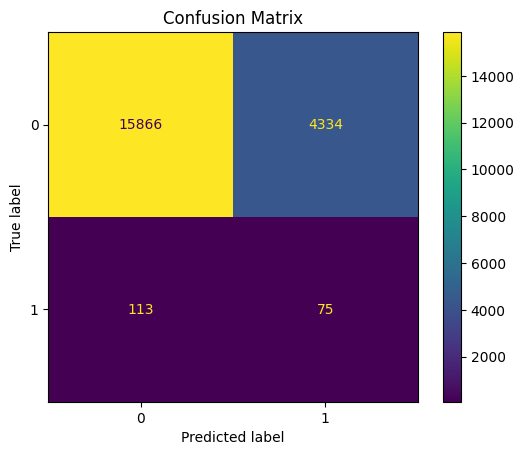

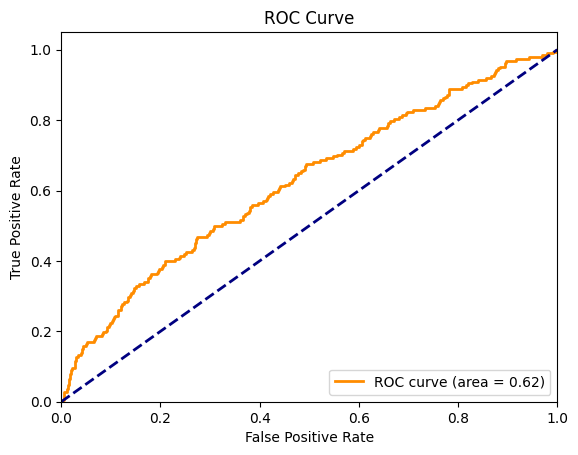

In [34]:
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

_f1_score = f1_score(y_test, y_pred)
_precision = precision_score(y_test, y_pred)
_auc = roc_auc_score(y_test, y_pred_proba)
print(
    f"SCORES: f1: {_f1_score:.4f}, prec: {_precision:.4f}, auc: {_auc:.4f}", end="\n\n"
)
print(classification_report(y_test, y_pred))

# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Krzywa ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

C:\Users\philipz\AppData\Local\Temp\ipykernel_18000\1455179441.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


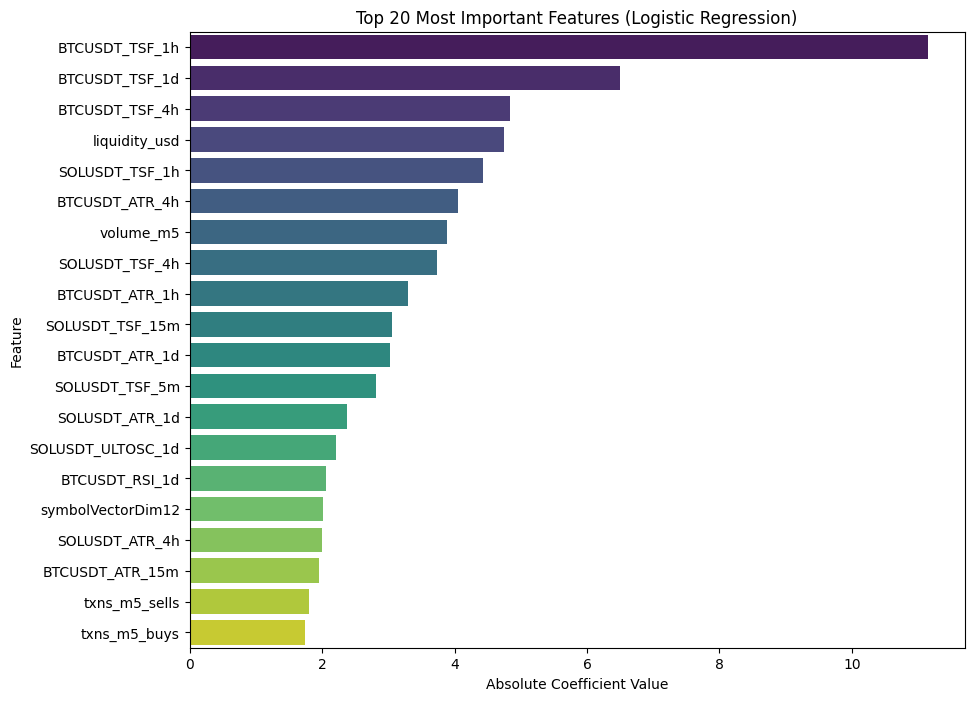

In [35]:
# Pobieranie współczynników modelu
coefficients = best_model.coef_[0]

# Tworzenie DataFrame z współczynnikami
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": coefficients,
    "Absolute_Coefficient": abs(coefficients)
})

# Sortowanie cech według wartości bezwzględnych współczynników
coef_df = coef_df.sort_values(by="Absolute_Coefficient", ascending=False)

# Rysowanie wykresu najważniejszych cech
plt.figure(figsize=(10, 8))
sns.barplot(
    data=coef_df.head(20),
    x="Absolute_Coefficient",
    y="Feature",
    palette="viridis"
)
plt.title("Top 20 Most Important Features (Logistic Regression)")
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Feature")
plt.show()

## XGBoost

In [36]:
# OLD
# gb_model = xgb.XGBClassifier(device="cuda",
#                              seed=RND_STATE)
# gb_model.fit(X_train_adasyn, y_train_adasyn)

# joblib.dump(gb_model, "models/default_xgb_model.joblib")
# y_pred = gb_model.predict(X_test)
# y_pred_proba = gb_model.predict_proba(X_test)[:, 1]

best_mcc = -1
best_method = None
best_model = None

results = []

for method_name, sampler in balance_methods.items():
    # Balansowanie danych
    X_res, y_res = sampler.fit_resample(X_train, y_train)
    
    # Trenowanie modelu XGBoost
    gb_model = xgb.XGBClassifier(
        device="cuda",
        seed=RND_STATE
    )
    gb_model.fit(X_res, y_res)
    
    # Predykcje
    y_pred = gb_model.predict(X_test)
    y_pred_proba = gb_model.predict_proba(X_test)[:, 1]
    
    # Obliczanie metryk
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    mcc = matthews_corrcoef(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    
    # Zapisywanie wyników
    results.append({
        'Method': method_name,
        'F1 Score': f1,
        'Precision': precision,
        'Recall': recall,
        'AUC': auc_score,
        'PR AUC': pr_auc,
        'MCC': mcc,
        'Balanced Accuracy': balanced_acc
    })
    
    # Wyświetlanie metryk
    print(f"Metoda: {method_name}")
    print(f"SCORES: f1: {f1:.4f}, prec: {precision:.4f}, recall: {recall:.4f}, auc: {auc_score:.4f}, pr_auc: {pr_auc:.4f}, mcc: {mcc:.4f}, balanced_acc: {balanced_acc:.4f}\n")
    
    # Aktualizacja najlepszego modelu na podstawie F1 Score
    if mcc > best_mcc:
        best_mcc = mcc
        best_method = method_name
        best_model = gb_model

# Zapis najlepszego modelu
if best_method:
    best_model_filename = f"models/default_xgb_model.joblib"
    joblib.dump(best_model, best_model_filename)
    print(f"Najlepsza metoda: {best_method} z MCC Score = {best_mcc:.4f}")
    print(f"Najlepszy model zapisany jako: {best_model_filename}")

# Tworzenie DataFrame z wynikami
results_df = pd.DataFrame(results)
print("\nPodsumowanie wyników:")
print(results_df)

Metoda: smote
SCORES: f1: 0.0564, prec: 0.0362, recall: 0.1277, auc: 0.7676, pr_auc: 0.0267, mcc: 0.0517, balanced_acc: 0.5480

Metoda: adasyn
SCORES: f1: 0.0467, prec: 0.0299, recall: 0.1064, auc: 0.7518, pr_auc: 0.0246, mcc: 0.0398, balanced_acc: 0.5371

Metoda: smote_borderline
SCORES: f1: 0.0063, prec: 0.0076, recall: 0.0053, auc: 0.7470, pr_auc: 0.0229, mcc: -0.0013, balanced_acc: 0.4994

Metoda: smote_enn
SCORES: f1: 0.0560, prec: 0.0345, recall: 0.1489, auc: 0.7631, pr_auc: 0.0265, mcc: 0.0538, balanced_acc: 0.5551

Metoda: smote_tomek
SCORES: f1: 0.0564, prec: 0.0362, recall: 0.1277, auc: 0.7676, pr_auc: 0.0267, mcc: 0.0517, balanced_acc: 0.5480

Metoda: enn
SCORES: f1: 0.0000, prec: 0.0000, recall: 0.0000, auc: 0.7856, pr_auc: 0.0283, mcc: -0.0015, balanced_acc: 0.4999

Metoda: cc
SCORES: f1: 0.0195, prec: 0.0098, recall: 0.9894, auc: 0.6393, pr_auc: 0.0177, mcc: 0.0229, balanced_acc: 0.5310

Metoda: default
SCORES: f1: 0.0000, prec: 0.0000, recall: 0.0000, auc: 0.7930, pr_auc

SCORES: f1: 0.0560, prec: 0.0345, auc: 0.7631

[[19416   784]
 [  160    28]]
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98     20200
         1.0       0.03      0.15      0.06       188

    accuracy                           0.95     20388
   macro avg       0.51      0.56      0.52     20388
weighted avg       0.98      0.95      0.97     20388



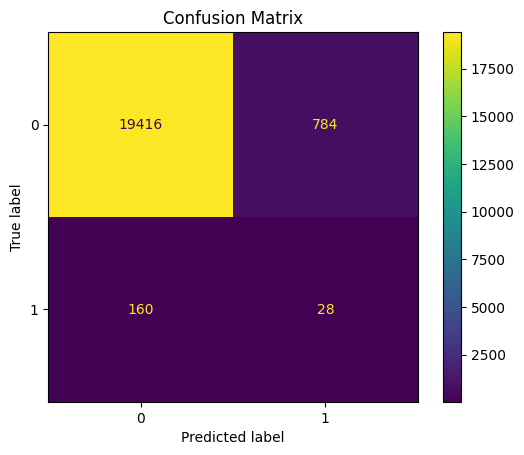

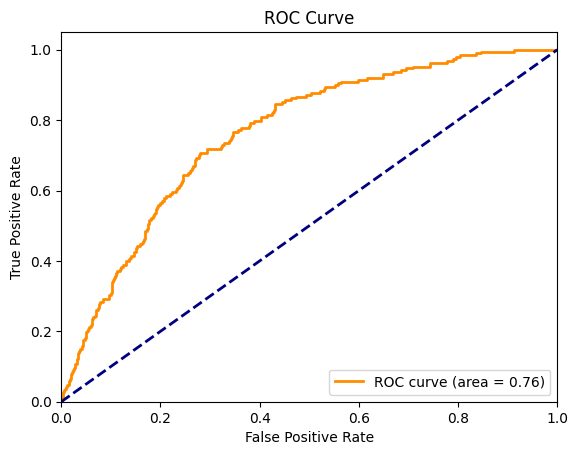

In [37]:
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

_f1_score = f1_score(y_test, y_pred)
_precision = precision_score(y_test, y_pred)
_auc = roc_auc_score(y_test, y_pred_proba)
print(
    f"SCORES: f1: {_f1_score:.4f}, prec: {_precision:.4f}, auc: {_auc:.4f}", end="\n\n"
)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Krzywa ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

<Figure size 1000x800 with 0 Axes>

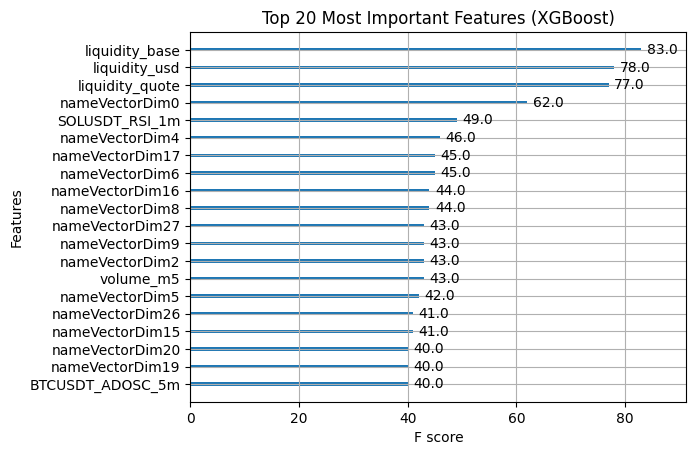

In [38]:
from xgboost import plot_importance

plt.figure(figsize=(10, 8))
plot_importance(gb_model, max_num_features=20, importance_type='weight', show_values=True)
plt.title("Top 20 Most Important Features (XGBoost)")
plt.show()

## SVM

In [ ]:
# Trenuj model SVM
svm_model = SVC(
    C=1.0,
    kernel="rbf",
    class_weight="balanced",
    # max_iter=100,
    # probability=True,
    random_state=RND_STATE,
)
svm_model.fit(X_train, y_train)
joblib.dump(svm_model, "models/default_svm_model.joblib")

# calibrated_svc = CalibratedClassifierCV(svm_model)
# calibrated_svc.fit(X_train, y_train)

# Dokonaj predykcji na zestawie testowym
y_pred = svm_model.predict(X_test)
y_pred_proba = svm_model.predict_proba(X_test)[:, 1]

In [ ]:
_f1_score = f1_score(y_test, y_pred)
_precision = precision_score(y_test, y_pred)
_auc = roc_auc_score(y_test, y_pred_proba)
print(
    f"SCORES: f1: {_f1_score:.4f}, prec: {_precision:.4f}, auc: {_auc:.4f}", end="\n\n"
)

print(classification_report(y_test, y_pred))

# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Krzywa ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

## Neural net (Tensorflow)

In [ ]:
# Budowa modelu z użyciem Input
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(280, activation="relu"))
model.add(Dropout(rate=0.5))
model.add(Dense(140, activation="relu"))
model.add(Dense(140, activation="relu"))
model.add(Dense(70, activation="relu"))
model.add(Dropout(rate=0.25))
model.add(Dense(1, activation="sigmoid"))

early_stopping = EarlyStopping(
    monitor="val_loss", mode="min", patience=10, restore_best_weights=True, verbose=1
)

# Kompilacja modelu
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=['auc'])

# Trenowanie modelu z użyciem class_weight
history = model.fit(
    X_train,
    y_train,
    epochs=250,
    # batch_size=8,
    # class_weight=class_weights,
    validation_split=0.1,
    callbacks=early_stopping,
)

# Ewaluacja modelu
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype("int32")

In [ ]:
_f1_score = f1_score(y_test, y_pred)
_precision = precision_score(y_test, y_pred)
_auc = roc_auc_score(y_test, y_pred_proba)
print(
    f"SCORES: f1: {_f1_score:.4f}, prec: {_precision:.4f}, auc: {_auc:.4f}", end="\n\n"
)

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Krzywa ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

## Neural net (PyTorch)

# Hiperparameter optimization

## Logistic regression

In [ ]:
class LogisticRegressionOptimizationProblem(ElementwiseProblem):
    def __init__(
        self, x_data, y_data, cv_folds=5, test_size=0.2, rnd_state=None, **kwargs
    ):
        self.x_data = x_data
        self.y_data = y_data
        self.cv_folds = cv_folds
        self.rnd_state = rnd_state
        self.test_size = test_size

        if cv_folds > 1:
            self.skf = StratifiedKFold(
                n_splits=cv_folds, shuffle=True, random_state=self.rnd_state
            )

        self.scorer = make_scorer(TUNING_SCORER)

        hyperparameters = {
            "penalty": Choice(options=["l1", "l2", "elasticnet", None]),
            "dual": Binary(),
            "C": Real(bounds=(0.0001, 10_000.0)),
            "fit_intercept": Binary(),
            "intercept_scaling": Real(bounds=(0.01, 100.0)),
            "solver": Choice(
                options=[
                    "newton-cg",
                    "newton-cholesky",
                    "lbfgs",
                    # "liblinear",
                    "sag",
                    "saga",
                ]
            ),
            "l1_ratio": Real(bounds=(0.0, 1.0)),  # Only used if penalty is 'elasticnet'
        }
        super().__init__(vars=hyperparameters, n_obj=1, **kwargs)

    def _evaluate(self, X, out, *args, **kwargs):
        print(f"X: {X}")
        if ((X["solver"] in ["sag", "newton-cg", "newton-cholesky", "lbfgs"]) and (
            X["penalty"] not in ["l2", None]
        )) or ((X["solver"] == "liblinear") and (X["penalty"] not in ["l1", "l2"])) or (X["dual"] and X["penalty"] != "l2" and X["solver"] != "liblinear")
        or ():
            # X["penalty"] = None
            out["F"] = np.inf
            print(f"Wrong arguments, score: {-out['F']}", end="\n\n")

        elif (X["solver"] == "liblinear") and (X["penalty"] not in ["l1", "l2"]):
            # X["penalty"] = "l1"
            out["F"] = np.inf
            print(f"Wrong arguments, score: {-out['F']}", end="\n\n")
        else:
            lr = LogisticRegression(
                class_weight="balanced",
                max_iter=100,
                penalty=X["penalty"],
                dual=(
                    X["dual"]
                    if X["penalty"] == "l2" and X["solver"] == "liblinear"
                    else False
                ),
                C=X["C"] if X["penalty"] != None else 1.0,
                fit_intercept=X["fit_intercept"],
                intercept_scaling=X["intercept_scaling"],
                solver=X["solver"],
                l1_ratio=X["l1_ratio"] if X["penalty"] == "elasticnet" else None,
                random_state=self.rnd_state,
                n_jobs=-1 if X["solver"] != "liblinear" else None
                )  # not implemented for this solver
    
            if self.cv_folds == 1:
                X_train, X_test, y_train, y_test = train_test_split(
                    self.x_data,
                    self.y_data,
                    test_size=self.test_size,
                    random_state=self.rnd_state,
                    stratify=self.y_data,
                )
                lr.fit(X_train, y_train)
                score = self.scorer(lr, X_test, y_test)
                print(f"Single split test score: {score}", end="\n\n")
                del X_train, X_test, y_train, y_test
            else:
                cv_scores = cross_val_score(
                    lr,
                    self.x_data,
                    self.y_data,
                    cv=self.skf,
                    scoring=self.scorer,
                    verbose=0,
                    n_jobs=-1,
                )
                score = np.mean(cv_scores)
                print(
                    f"{self.cv_folds} folds cross-validated mean score: {score}", end="\n\n"
                )
            del lr
            out["F"] = -score

In [ ]:
# pool = Pool(cpu_count())
# runner = StarmapParallelization(pool.starmap)

problem = LogisticRegressionOptimizationProblem(
    X_train, y_train, cv_folds=5, rnd_state=None
)
algorithm = GA(
    pop_size=TUNING_POPSIZE,
    sampling=MixedVariableSampling(),
    mating=MixedVariableMating(
        eliminate_duplicates=MixedVariableDuplicateElimination()
    ),
    eliminate_duplicates=MixedVariableDuplicateElimination(),
)

res = minimize(
    problem,
    algorithm,
    termination=("time", "9:00:00"),
    # termination=("n_gen", TUNING_NGEN),
    verbose=True,
)
print(f'X_train.shpae {X_train.shape}')
print(f'y_train.shpae {y_train.shape}')

In [ ]:
if len(res.F) == 1:
    if isinstance(res.X, dict):
        print(f"Best gene: reward= {-res.f} variables= {res.X.items()}")
    else:
        print(f"Best gene: reward= {-res.f} variables= {res.X}")
else:
    print("Pareto front:")
    for front, var in zip(res.F, res.X):
        print(f"front=", front, "variables=", list(var.values()))

In [ ]:
# Manula
lr = LogisticRegression(
    class_weight="balanced",
    random_state=RND_STATE,
    n_jobs=-1,
    max_iter=100,
    penalty='l2',
    dual=False,
    C=237.34426130555164,
    fit_intercept=True,
    intercept_scaling=38.422685561731,
    solver='saga',
    l1_ratio=0.19674622148550575,
)

# lr = LogisticRegression(
#     class_weight="balanced",
#     random_state=RND_STATE,
#     n_jobs=(
#         -1 if res.X["solver"] != "liblinear" else None
#     ),  # not implemented for this solver
#     max_iter=1_000,
#     penalty=res.X["penalty"],
#     dual=(
#         res.X["dual"]
#         if res.X["penalty"] == "l2" and res.X["solver"] == "liblinear"
#         else False
#     ),
#     C=res.X["C"] if res.X["penalty"] != None else 1.0,
#     fit_intercept=res.X["fit_intercept"],
#     intercept_scaling=res.X["intercept_scaling"],
#     solver=res.X["solver"],
#     l1_ratio=res.X["l1_ratio"] if res.X["penalty"] == "elasticnet" else None,
# )

lr.fit(X_train, y_train)
joblib.dump(lr, "models/tuned_lr_model.joblib")

# Dokonaj predykcji na zestawie testowym
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)[:, 1]

In [ ]:
_f1_score = f1_score(y_test, y_pred)
_precision = precision_score(y_test, y_pred)
_auc = roc_auc_score(y_test, y_pred_proba)
print(
    f"SCORES: f1: {_f1_score:.4f}, prec: {_precision:.4f}, auc: {_auc:.4f}", end="\n\n"
)
print(classification_report(y_test, y_pred))

# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Krzywa ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

## Random Forest

In [ ]:
class RFMixedVariableProblem(ElementwiseProblem):
    def __init__(
        self, x_data, y_data, cv_folds=5, test_size=0.2, rnd_state=None, **kwargs
    ):
        self.x_data = x_data
        self.y_data = y_data
        self.cv_folds = cv_folds
        self.rnd_state = rnd_state
        self.test_size = test_size

        if cv_folds > 1:
            self.skf = StratifiedKFold(
                n_splits=cv_folds, shuffle=True, random_state=self.rnd_state
            )

        self.scorer = make_scorer(TUNING_SCORER)
        
        hyperparameters = {
            "n_estimators": Integer(bounds=(1, 500)),
            "criterion": Choice(options=["gini", "entropy"]),
            "max_depth": Integer(bounds=(1, 200)),
            "min_samples_split": Real(bounds=(0.0, 1.0)),
            "min_samples_leaf": Real(bounds=(0.0, 1.0)),
            "min_weight_fraction_leaf": Real(bounds=(0.0, 0.5)),
            "max_features": Real(bounds=(0.001, 1.000)),
            "max_leaf_nodes": Integer(bounds=(2, 200)),
            "min_impurity_decrease": Real(bounds=(0.0, 1.5)),
            "class_weight": Choice(options=["balanced", "balanced_subsample", None]),
            # "bootstrap": Binary(),
            # "oob_score": Binary(),
            # "warm_start": Binary(),
            # # "ccp_alpha": Real(bounds=(0.0, 10.0)),
            # "max_samples": Real(bounds=(0.001, 1.000)),
            # "monotonic_cst": Choice(options=[1, 0, -1, None])
        }
        super().__init__(vars=hyperparameters, n_obj=1, **kwargs)

    def _evaluate(self, X, out, *args, **kwargs):
        print(f"X: {X}")
        brf = BalancedRandomForestClassifier(
            n_jobs=-1,
            sampling_strategy="all",
            replacement=False,
            random_state=self.rnd_state,
            n_estimators=X["n_estimators"],
            criterion=X["criterion"],
            max_depth=X["max_depth"],
            min_samples_split=X["min_samples_split"],
            min_samples_leaf=X["min_samples_leaf"],
            min_weight_fraction_leaf=X["min_weight_fraction_leaf"],
            max_features=X["max_features"],
            max_leaf_nodes=X["max_leaf_nodes"],
            min_impurity_decrease=X["min_impurity_decrease"],
            class_weight=X["class_weight"],
            # bootstrap=X['bootstrap'],
            # oob_score=X['oob_score'] if X['bootstrap'] else False,
            # warm_start=X['warm_start'],
            # class_weight=X['class_weight'] if not X['warm_start'] else None,
            # # ccp_alpha=X['ccp_alpha'],
            # max_samples=None if not X['bootstrap'] else X['max_samples'],
            # monotonic_cst=X['monotonic_cst']
        )
        if self.cv_folds == 1:
            X_train, X_test, y_train, y_test = train_test_split(
                self.x_data,
                self.y_data,
                test_size=self.test_size,
                random_state=self.rnd_state,
                stratify=self.y_data,
            )
            brf.fit(X_train, y_train)
            score = self.scorer(brf, X_test, y_test)
            print(f"Single split test score: {score}", end="\n\n")
        else:
            cv_scores = cross_val_score(
                brf,
                self.x_data,
                self.y_data,
                cv=self.skf,
                scoring=self.scorer,
                n_jobs=-1,
            )
            score = np.min(cv_scores)
            print(
                f"{self.cv_folds} folds cross-validated minimal score: {score}", end="\n\n"
            )

        out["F"] = -score

In [ ]:
# pool = Pool(cpu_count())
# runner = StarmapParallelization(pool.starmap)

problem = RFMixedVariableProblem(X_train, y_train, cv_folds=4, rnd_state=None)
algorithm = GA(
    pop_size=TUNING_POPSIZE,
    sampling=MixedVariableSampling(),
    mating=MixedVariableMating(
        eliminate_duplicates=MixedVariableDuplicateElimination()
    ),
    eliminate_duplicates=MixedVariableDuplicateElimination(),
)

res = minimize(
    problem,
    algorithm,
    # termination=("time", "09:00:00"),
    termination=("n_gen", TUNING_NGEN),
    verbose=True,
)

In [ ]:
if len(res.F) == 1:
    if isinstance(res.X, dict):
        print(f"Best gene: reward= {-res.f} variables= {res.X.items()}")
    else:
        print(f"Best gene: reward= {-res.f} variables= {res.X}")
else:
    print("Pareto front:")
    for front, var in zip(res.F, res.X):
        print(f"front=", front, "variables=", list(var.values()))

In [ ]:
# Inicjalizacja modelu Random Forest
rf_model = BalancedRandomForestClassifier(
            n_jobs=-1,
            sampling_strategy="all",
            bootstrap=False,
            replacement=False,
            random_state=RND_STATE,
            n_estimators=res.X["n_estimators"],
            criterion=res.X["criterion"],
            max_depth=res.X["max_depth"],
            min_samples_split=res.X["min_samples_split"],
            min_samples_leaf=res.X["min_samples_leaf"],
            min_weight_fraction_leaf=res.X["min_weight_fraction_leaf"],
            max_features=res.X["max_features"],
            max_leaf_nodes=res.X["max_leaf_nodes"],
            min_impurity_decrease=res.X["min_impurity_decrease"],
            class_weight=res.X["class_weight"]
)

# Trenowanie modelu na danych treningowych
rf_model.fit(X_train, y_train)
joblib.dump(rf_model, "models/tuned_rf_model.joblib")

# Przewidywanie na zbiorze testowym
y_pred = rf_model.predict(X_test)

In [ ]:
# # Inicjalizacja modelu Random Forest
# rf_model = BalancedRandomForestClassifier(
#     n_jobs=-1,
#     replacement=True,
#     sampling_strategy="all",
#     random_state=None,
#     n_estimators=246,
#     max_depth=156,
#     max_leaf_nodes=24,
#     criterion="gini",
#     class_weight=None,
#     min_samples_split=0.09369105882160408,
#     min_samples_leaf=0.02751719540215013,
#     min_weight_fraction_leaf=0.045328246137509784,
#     max_features=0.8037848114419907,
#     min_impurity_decrease=0.8037848114419907,
#     # bootstrap=False,
#     # oob_score=False,
#     # warm_start=False
# )

# # Trenowanie modelu na danych treningowych
# rf_model.fit(X_train, y_train)

# # Przewidywanie na zbiorze testowym
# y_pred = rf_model.predict(X_test)
# joblib.dump(rf_model, "models/tuned_rf_model.joblib")

# # Ocena modelu
# accuracy = f1_score(y_test, y_pred)
# print(f"Score: {accuracy}")

# # Dodatkowa ocena za pomocą classification report
# report = classification_report(y_test, y_pred)
# print(report)

In [ ]:
_f1_score = f1_score(y_test, y_pred)
_precision = precision_score(y_test, y_pred)
_auc = roc_auc_score(y_test, y_pred)
print(
    f"SCORES: f1: {_f1_score:.4f}, prec: {_precision:.4f}, auc: {_auc:.4f}", end="\n\n"
)
print(classification_report(y_test, y_pred))

# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Krzywa ROC
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Obliczanie średniej ważności cech
feature_importances = rf_model.estimators_[0].feature_importances_
for estimator in rf_model.estimators_[1:]:
    feature_importances += estimator.feature_importances_
feature_importances /= len(rf_model.estimators_)

# Tworzenie DataFrame z ważnościami cech
feature_importance_df = pd.DataFrame(
    {"Feature": X.columns, "Importance": feature_importances}
)

# Sortowanie cech według ważności
feature_importance_df = feature_importance_df.sort_values(
    by="Importance", ascending=False
)

# Rysowanie wykresu ważności cech
plt.figure(figsize=(10, 8))
sns.barplot(
    data=feature_importance_df.head(20), x="Importance", y="Feature", palette="viridis"
)
plt.title("Top 20 Most Important Features")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()

## SVM

In [ ]:
class SVMMixedVariableProblem(ElementwiseProblem):
    def __init__(
        self, x_data, y_data, cv_folds=5, n_estimators=4, rnd_state=None, **kwargs
    ):
        self.x_data = x_data
        self.y_data = y_data
        self.cv_folds = cv_folds
        self.rnd_state = rnd_state
        self.n_estimators = n_estimators

        self.skf = StratifiedKFold(
            n_splits=cv_folds, shuffle=False, random_state=rnd_state
        )
        self.scorer = make_scorer(TUNING_SCORER)
        hyperparameters = {
            "C": Real(bounds=(0.0001, 10_000.0)),
            "kernel": Choice(options=["linear", "poly", "rbf", "sigmoid"]),
            "degree": Integer(bounds=(2, 15)),
            # "gamma": Choice(options=["scale", "auto"]),
            "gamma": Real(bounds=(0.0001, 1.0)),  # causes problems with model
            "coef0": Real(bounds=(-15.0, 15.0)),
            "shrinking": Binary(),
            # "probability": Binary(), # False calculates faster
            # "tol": Real(bounds=(0.0001, 0.01)), # all models should have equal
            # "cache_size": Integer(bounds=(200, 1000)),
            # "class_weight": Choice(options=["balanced", None]),
            # "max_iter": Integer(bounds=(-1, 1000))
        }
        super().__init__(vars=hyperparameters, n_obj=1, **kwargs)

    def _evaluate(self, X, out, *args, **kwargs):
        print(f"X: {X}")
        try:
            svm = SVC(
                max_iter=50,
                class_weight="balanced",
                probability=False,
                C=X["C"],
                kernel=X["kernel"],
                degree=X["degree"],
                gamma=X["gamma"],
                coef0=X["coef0"],
                shrinking=bool(X["shrinking"]),
                # probability=bool(X['probability']),
                # tol=X['tol'], # stopping criterion, may cause troubles
                # cache_size=X['cache_size'],
                # class_weight=X['class_weight'],
                # max_iter=X['max_iter']
            )
            # b_svc= BaggingClassifier(svm,
            #                          max_samples=1.0 / self.n_estimators,
            #                          n_estimators=self.n_estimators,
            #                          n_jobs=-1)
            cv_scores = cross_val_score(
                svm,
                self.x_data,
                self.y_data,
                cv=self.skf,
                scoring=self.scorer,
                error_score="raise",
                n_jobs=-1,
            )
            mean_f1 = np.mean(cv_scores)
            print(
                f"{self.cv_folds} folds cross-validated mean score: {mean_f1}",
                end="\n\n",
            )
            out["F"] = -mean_f1
        except Exception as e:
            print(e)
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print(f"Model failure with prameters: {X}")
            print(
                f"{self.cv_folds} folds cross-validated mean score: -{np.inf}",
                end="\n\n",
            )
            out["F"] = np.inf
            # raise e

In [ ]:
# pool = Pool(cpu_count())
# runner = StarmapParallelization(pool.starmap)

problem = SVMMixedVariableProblem(
    X_train, y_train, cv_folds=4, n_estimators=4, rnd_state=None
)
algorithm = GA(
    pop_size=128,
    sampling=MixedVariableSampling(),
    mating=MixedVariableMating(
        eliminate_duplicates=MixedVariableDuplicateElimination()
    ),
    eliminate_duplicates=MixedVariableDuplicateElimination(),
)

res = minimize(
    problem,
    algorithm,
    termination=("time", "08:00:00"),
    # termination=("n_gen", 50),
    verbose=True,
)

In [ ]:
if len(res.F) == 1:
    if isinstance(res.X, dict):
        print(f"Best gene: reward= {-res.f} variables= {res.X.items()}")
    else:
        print(f"Best gene: reward= {-res.f} variables= {res.X}")
else:
    print("Pareto front:")
    for front, var in zip(res.F, res.X):
        print(f"front=", front, "variables=", list(var.values()))

In [ ]:
# Trenuj model SVM

svm_model = SVC(
    max_iter=-1,
    C=8149.480638948695,
    coef0=-13.40974924059736,
    # tol=0.007392566629174455,
    kernel="rbf",
    gamma=0.028951614538558074,
    class_weight="balanced",
    degree=15,
    shrinking=False,
    probability=True,
)

# n_estimators = 4
# b_svc= BaggingClassifier(svm_model, max_samples=1.0 / n_estimators, n_estimators=n_estimators, n_jobs=-1)
# b_svc.fit(X_train, y_train)

svm_model.fit(X_train_res, y_train_res)
joblib.dump(svm_model, "models/tuned_svm_model.joblib")

# calibrated_svc = CalibratedClassifierCV(svm_model)
# calibrated_svc.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

score = f1_score(y_test, y_pred)
print(f"Score: {score}")

print(classification_report(y_test, y_pred))

In [ ]:
# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Krzywa ROC
y_pred_proba = svm_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

## XGBoost (edit needed)

In [ ]:
class GradientBoostingOptimizationProblem(ElementwiseProblem):
    def __init__(self, x_data, y_data, cv_folds=5, rnd_state=None, **kwargs):
        self.x_data = x_data
        self.y_data = y_data
        self.cv_folds = cv_folds
        self.rnd_state = rnd_state

        self.skf = StratifiedKFold(
            n_splits=cv_folds, shuffle=True, random_state=rnd_state
        )
        self.scorer = make_scorer(TUNING_SCORER)

        hyperparameters = {
            "loss": Choice(options=["log_loss", "exponential"]),
            "learning_rate": Real(bounds=(0.001, 1000.0)),
            "n_estimators": Integer(bounds=(5, 500)),
            "subsample": Real(bounds=(0.01, 1.0)),
            "criterion": Choice(options=["friedman_mse", "squared_error"]),
            "min_samples_split": Real(bounds=(0.001, 1.0)),
            "min_samples_leaf": Real(bounds=(0.001, 1.0)),
            "min_weight_fraction_leaf": Real(bounds=(0.0, 0.5)),
            "max_depth": Integer(bounds=(1, 100)),
            "min_impurity_decrease": Real(bounds=(0.0, 100.0)),
            "max_features": Choice(options=["sqrt", "log2", None]),
            "max_leaf_nodes": Integer(bounds=(2, 100), strict=False),
            "validation_fraction": Real(bounds=(0.01, 0.5)),
        }
        super().__init__(vars=hyperparameters, n_obj=1, **kwargs)

    def _evaluate(self, X, out, *args, **kwargs):
        print(f"X: {X}")
        gbc = GradientBoostingClassifier(
            loss=X["loss"],
            learning_rate=X["learning_rate"],
            n_estimators=X["n_estimators"],
            subsample=X["subsample"],
            criterion=X["criterion"],
            min_samples_split=X["min_samples_split"],
            min_samples_leaf=X["min_samples_leaf"],
            min_weight_fraction_leaf=X["min_weight_fraction_leaf"],
            max_depth=X["max_depth"],
            min_impurity_decrease=X["min_impurity_decrease"],
            max_features=X["max_features"],
            max_leaf_nodes=X["max_leaf_nodes"],
            validation_fraction=X["validation_fraction"],
            random_state=self.rnd_state,
        )

        cv_scores = cross_val_score(
            gbc, self.x_data, self.y_data, cv=self.skf, scoring=self.scorer, n_jobs=-1
        )
        mean_f1_score = np.mean(cv_scores)
        print(
            f"{self.cv_folds} folds cross-validated mean score: {mean_f1_score}",
            end="\n\n",
        )

        out["F"] = -mean_f1_score

In [ ]:
# pool = Pool(cpu_count())
# runner = StarmapParallelization(pool.starmap)

problem = GradientBoostingOptimizationProblem(
    X_train, y_train, cv_folds=4, rnd_state=None
)
algorithm = GA(
    pop_size=TUNING_POPSIZE,
    sampling=MixedVariableSampling(),
    mating=MixedVariableMating(
        eliminate_duplicates=MixedVariableDuplicateElimination()
    ),
    eliminate_duplicates=MixedVariableDuplicateElimination(),
)

res = minimize(
    problem,
    algorithm,
    # termination=("time", "02:00:00"),
    termination=("n_gen", TUNING_NGEN),
    verbose=True,
)

In [ ]:
# scores = []
# for i in range(2, 25):
#   kmeans = KMeans(n_clusters=i)
#   clusters = kmeans.fit_predict(std_modeling.drop(columns=['worthy']))

#   # Ewaluacja klastrów
#   score = silhouette_score(std_modeling, clusters)
#   print(f"k={i} Silhouette Score: {score}")
#   scores.append(score)

## Neural net

In [ ]:
# from tensorflow.keras import callbacks, regularizers
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
# from tensorflow.keras.optimizers import Adam
# from keras_tuner import HyperModel, Objective
# from keras_tuner.tuners import BayesianOptimization

# from datetime import datetime


# class MyHyperModel(HyperModel):
#     def __init__(self, input_shape):
#         self.input_shape = input_shape

#     def build(self, hp):
#         model = Sequential()
#         # Pierwsza warstwa Dense
#         model.add(
#             Dense(
#                 units=hp.Int("units_input", min_value=8, max_value=256, step=8),
#                 activation=hp.Choice("activation_input", ["relu", "elu"]),
#                 kernel_regularizer=regularizers.l2(
#                     hp.Float("l2_input", min_value=1e-5, max_value=1e-1)
#                 ),
#                 input_shape=(self.input_shape,),
#             )
#         )

#         # Opcjonalna warstwa BatchNormalization po pierwszej warstwie Dense
#         if hp.Boolean("batch_norm_input"):
#             model.add(BatchNormalization())

#         # Opcjonalna warstwa Dropout po pierwszej warstwie Dense
#         if hp.Boolean("dropout_input"):
#             model.add(
#                 Dropout(
#                     rate=hp.Float(
#                         "dropout_input_rate", min_value=0.0, max_value=0.75, step=0.05
#                     )
#                 )
#             )

#         # Dodatkowe warstwy Dense
#         for i in range(hp.Int("num_layers", 1, 8)):
#             model.add(
#                 Dense(
#                     units=hp.Int(
#                         f"units_layer_{i}", min_value=16, max_value=256, step=16
#                     ),
#                     activation=hp.Choice(f"activation_{i}", ["relu", "elu"]),
#                     kernel_regularizer=(
#                         regularizers.l2(
#                             hp.Float(f"l2_layer_{i}", min_value=1e-5, max_value=1e-1)
#                         )
#                         if hp.Boolean(f"l2_layer_{i}_reg")
#                         else None
#                     ),
#                 )
#             )

#             # Opcjonalna warstwa Dropout po każdej dodatkowej warstwie Dense
#             model.add(
#                 Dropout(
#                     rate=hp.Float(
#                         f"dropout_layer_{i}", min_value=0.0, max_value=0.5, step=0.05
#                     )
#                 )
#             )

#         model.add(Dense(1, activation="sigmoid"))

#         model.compile(
#             optimizer=Adam(hp.Float("learning_rate", min_value=1e-5, max_value=1e-2)),
#             loss="binary_crossentropy",
#             metrics=["accuracy"],
#         )
#         return model

#     def fit(self, hp, model, *args, **kwargs):
#         return model.fit(
#             *args,
#             batch_size=hp.Choice("batch_size", values=[2, 4, 8, 16, 32]),
#             **kwargs,
#         )


# hypermodel = MyHyperModel(input_shape=X_train_scaled.shape[1])

# tuner = BayesianOptimization(
#     hypermodel,
#     objective=Objective("val_accuracy", direction="max"),
#     max_trials=100,
#     executions_per_trial=2,
#     directory=f"search{datetime.now()}",
#     project_name=f"dupxo{datetime.now()}",
# )

# # Rozpocznij proces wyszukiwania. Pamiętaj, aby zastąpić `X_train_scaled`, `y_train` swoimi danymi.
# tuner.search(
#     X_train_scaled,
#     y_train,
#     epochs=500,
#     #  batch_size=16,
#     validation_split=0.2,
#     callbacks=[
#         callbacks.EarlyStopping(monitor="loss", mode="min", patience=5, verbose=1)
#     ],
# )

# best_model = tuner.get_best_models(num_models=1)[0]
# best_model.save("/content/drive/MyDrive/models/token_selectioner_best_model.h5")

# tuner.results_summary()
# test_loss, test_acc = best_model.evaluate(X_test_scaled, y_test)
# print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

In [ ]:
# Podział danych z użyciem stratyfikacji
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=RND_STATE
)

# Definiowanie funkcji budującej model
def build_model(hp):
    # Wybór optymalizatora
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG'))
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG'))
    else:
        optimizer = SGD(learning_rate=hp.Float('learning_rate', 1e-4, 1e-1, sampling='LOG'))
    
    model = Sequential()
    # Warstwa wejściowa
    model.add(Input(shape=(X_train.shape[1],)))

    # Warstwy ukryte w pętli
    for i in range(hp.Int('num_layers', 1, 7)):
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=8, max_value=256, step=8),
            activation=hp.Choice(f'activation_{i}', ['relu', 'tanh', 'elu']),
            kernel_regularizer=l1_l2(
                l1=hp.Float(f'l1_{i}', 0.0, 1e-3, sampling='linear'),
                l2=hp.Float(f'l2_{i}', 0.0, 1e-3, sampling='linear')
            )
        ))

        # Batch normalization i dropout dla każdej warstwy, jeśli określono
        if hp.Boolean(f'batch_norm_{i}'):
            model.add(BatchNormalization())
        if hp.Boolean(f'dropout_{i}'):
            model.add(Dropout(rate=hp.Float(f'dropout_rate_{i}', min_value=0.05, max_value=0.5, step=0.05)))

    # Warstwa wyjściowa
    model.add(Dense(1, activation='sigmoid'))

    # Kompilacja modelu z użyciem metryki AUC
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['auc']
    )
    return model

# Tuner settings
tuner = BayesianOptimization(
    build_model,
    objective="val_auc",
    max_trials=75,
    executions_per_trial=2,
    directory=f"models/NN_tuning",
    project_name=re.sub(r'[\/:*?"<>|]', '', f"tunedNN_{datetime.now()}"),
)
# tuner = Hyperband(
#     build_model,
#     objective='val_f1_score',
#     max_epochs=50,
#     factor=3,
#     directory=f"models/NN_tuning",
#     project_name=re.sub(r'[\/:*?"<>|]', '', f"tunedNN_{datetime.now()}"),
#     seed=RND_STATE
# )

# Callback settings
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    mode='min'
)

# Train tuner with validation data
tuner.search(
    X_train_split, y_train_split,
    epochs=50,
    validation_data=(X_val_split, y_val_split),
    callbacks=[early_stopping]
)

# Wyświetlanie wyników tuningu
tuner.results_summary()

In [ ]:
# !nvidia-smi
import tensorflow as tf

# Sprawdzenie dostępnych urządzeń
physical_devices = tf.config.list_physical_devices('GPU')
print("Wykryte GPU:", physical_devices)

if len(physical_devices) > 0:
    print("Nazwa GPU:", tf.config.experimental.get_device_details(physical_devices[0])['device_name'])
else:
    print("Brak wykrytych GPU")

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

# Ewaluacja modelu
loss, score = best_model.evaluate(X_test, y_test)
print(f"Test Score: {f1:.2f}")

y_pred = (best_model.predict(X_test) > 0.5).astype("int32")

_f1_score = f1_score(y_test, y_pred)
_precision = precision_score(y_test, y_pred)
_auc = roc_auc_score(y_test, y_pred)
print(
    f"SCORES: f1: {_f1_score:.4f}, prec: {_precision:.4f}, auc: {_auc:.4f}", end="\n\n"
)

print("Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Krzywa ROC
y_pred_proba = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()